<a href="https://colab.research.google.com/github/brahma2024/Deep-Implicit-Layers/blob/main/Ch2_1_ImplicitFunc%2BAutoDiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2: Implicit Functions and Automatic Differentiation

https://implicit-layers-tutorial.org/implicit_functions/
- exploring methods to compute Numerical Fixed points
- This chapter uses JAX (instead of Pytorch)

Covers:
- [Naive Forward iterations](https://en.wikipedia.org/wiki/Fixed-point_iteration) for computing fixed point
- [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) to compute fixed point
- [Anderson Acceleration](https://en.wikipedia.org/wiki/Anderson_acceleration) to compute fixed point

In [ ]:
!pip install fvcore
# import jax.numpy as jnp
import torch
import torch.profiler
from torch.autograd import grad
from torch.autograd import functional
import numpy as np
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=7f4399d9fe4103631b5fd069208c9b5bef69890ec5859ab965e0329777370167
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=329819414fe9e55743db88e1a19ec33f09107949c1dd47b59f814ab053657e97
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
# Define the naive forward iteration solver
def fwd_solver(f, z_init):
  z_prev, z = z_init, f(z_init)
  # print(f'{f(z_init)=}')
  # print(f'{jnp.linalg.norm(z_prev - z)=}')

  # jax implementation
  # while jnp.linalg.norm(z_prev - z) > 1e-5:

  # pytorch implementation
  while torch.norm(z_prev - z) > 1e-5:
    z_prev, z = z, f(z)
    # print(f'{torch.norm(z_prev - z)=}')
  return z

In [ ]:
# import jax
from torch.autograd.functional import jacobian

# Define the Newtown's Iteration method as a solver
def newton_solver(f, z_init):
  f_root = lambda z: f(z) - z
  # g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z)) # jax implementation
  g = lambda z: z - torch.linalg.solve(jacobian(f_root, z), f_root(z)) # pytoch implementation
  return fwd_solver(g, z_init)

In [ ]:
# Define the Anderson Acceleartion solver
def anderson_solver(f, z_init, m=5, lam=1e-4, max_iter=50, tol=1e-5, beta=1.0):
  x0 = z_init
  x1 = f(x0)
  x2 = f(x1)
  # jax implementation
  # X = jnp.concatenate([jnp.stack([x0, x1]), jnp.zeros((m - 2, *jnp.shape(x0)))])
  # F = jnp.concatenate([jnp.stack([x1, x2]), jnp.zeros((m - 2, *jnp.shape(x0)))])

  # pytorch implementation
  X = torch.cat([torch.stack((x0, x1)), torch.zeros((m - 2, *x0.shape))])
  F = torch.cat([torch.stack((x1, x2)), torch.zeros((m - 2, *x0.shape))])

  res = []
  for k in range(2, max_iter):
    n = min(k, m)
    G = F[:n] - X[:n]
    GTG = torch.tensordot(G, G, [list(range(1, G.ndim))] * 2)
    # jax implementation
    # H = jnp.block([[jnp.zeros((1, 1)), jnp.ones((1, n))],
    #               [jnp.ones((n, 1)), GTG]]) + lam * jnp.eye(n + 1)
    # alpha = jnp.linalg.solve(H, jnp.zeros(n+1).at[0].set(1))[1:]
    # xk = beta * torch.dot(alpha, F[:n]) + (1-beta) * torch.dot(alpha, X[:n])
    # X = X.at[k % m].set(xk)
    # F = F.at[k % m].set(f(xk))

    # pytorch implementation
    H = torch.cat([torch.cat([torch.zeros((1, 1)), torch.ones((1, n))], dim=1),
                   torch.cat([torch.ones((n, 1)), GTG], dim=1)], dim=0) + lam * torch.eye(n + 1)
    rhs = torch.zeros(n + 1)
    rhs[0] = 1  # Set the first element to 1
    alpha = torch.linalg.solve(H, rhs)[1:]

    xk = beta * torch.matmul(alpha, F[:n]) + (1-beta) * torch.matmul(alpha, X[:n])
    X[k % m] = xk
    F[k % m] = f(xk)

    res = torch.linalg.norm(F[k % m] - X[k % m]) / (1e-5 + torch.linalg.norm(F[k % m]))
    if res < tol:
      break

  return xk

**Fixed Point Layer**

The layer takes as arguments

1. a solver, aptly named solver,
2. a function f for which to find the fixed point,
3. parameters params, and
4. input values x.

With those inputs, it computes as its output the fixed-point of the function.

Here’s the function f we’ll use, so that its paramters are just a weight matrix W:

    f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)

In [ ]:
# Creating a toy DEQ (Deep Equilibrium) fixed-point layer, which can use any of the solvers deployed above
def fixed_point_layer(solver, f, params, x):
  # z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
  z_star = solver(lambda z: f(params, x, z), z_init=torch.zeros_like(x))
  return z_star

In [ ]:
# define the function
# f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)
f = lambda W, x, z: torch.tanh(torch.matmul(W, z) + x)

In [ ]:
# from jax import random
# import jax.numpy as jnp
torch.manual_seed(0)

# initialize some random values for the parameters and inputs:
ndim = 10
# W = random.normal(random.PRNGKey(0), (ndim, ndim)) / jnp.sqrt(ndim)
# x = random.normal(random.PRNGKey(1), (ndim,))
W = torch.randn((ndim, ndim)) / torch.sqrt(torch.tensor(ndim, dtype=torch.float32))
x = torch.randn((ndim,))
W = torch.tensor(W, requires_grad=True)
x = torch.tensor(x, requires_grad=True)
print(f'{W.shape=} | {x.shape=}')
print(f'{W=} | {x=}')

W.shape=torch.Size([10, 10]) | x.shape=torch.Size([10])
W=tensor([[-3.5602e-01, -3.6441e-01, -7.9240e-02, -1.3720e-01,  2.6839e-01,
          2.1883e-01, -9.9932e-02, -6.6889e-01,  1.0191e-01, -3.9950e-01],
        [ 1.1067e-01,  9.7441e-02,  3.7897e-02,  3.9138e-01,  3.5316e-01,
         -7.8196e-02, -4.2775e-01, -5.3630e-01,  1.7919e-01,  2.5093e-01],
        [ 1.8937e-01, -4.9176e-01, -1.0795e-01,  5.8597e-01,  2.3723e-01,
         -1.8515e-01, -5.4833e-02,  5.8021e-02,  4.3936e-01,  5.0164e-01],
        [ 2.9925e-01, -2.6679e-01, -1.9403e-01,  9.9905e-03, -1.5580e-01,
          7.8556e-02,  1.3904e-01,  3.5548e-02,  2.0264e-01,  1.3951e-01],
        [-3.2353e-02,  2.5059e-01, -9.1601e-02,  1.6604e-02,  1.6534e-01,
          7.2802e-01, -4.6451e-01, -5.0176e-01, -2.1285e-01,  2.7601e-01],
        [ 3.3373e-01,  5.6239e-02, -7.2838e-02, -1.2388e-01,  1.7180e-01,
         -1.2496e-01, -1.4111e-01,  2.3528e-01,  4.8098e-01,  1.0785e+00],
        [-4.8420e-01, -3.9027e-01,  5.7545e-01, 

<ipython-input-7-8571e11073b7>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W, requires_grad=True)
<ipython-input-7-8571e11073b7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, requires_grad=True)


In [ ]:
# taking weights + input values same as from jax.random
# compare jax and pytorch output for same set of initialized weights and inputs
# W = torch.tensor([[-0.62646943,  0.3314612 ,  0.2813855 ,  0.01112047, -0.29958108,
#          0.26919097,  0.00988069, -0.12322951,  0.00417674, -0.1329807 ],
#        [-0.3900877 , -0.39605355,  0.31223935,  0.254865  , -0.12991595,
#          0.30794927, -0.21753468, -0.25078502, -0.62400335,  0.04913804],
#        [-0.1836838 ,  0.5016327 ,  0.09010185,  0.20182689,  0.01919276,
#          0.12584354, -0.07185219, -0.22306114,  0.20778245, -0.57114726],
#        [ 0.32912743, -0.6233769 , -0.02189714,  0.190992  , -0.12137587,
#          0.10278042,  0.08896769, -0.47816026,  0.27667585, -0.25164938],
#        [ 0.1188938 , -0.1439303 ,  0.04284617,  0.3795554 ,  0.55041873,
#          0.31262004, -0.00856635, -0.37457463, -0.30257002,  0.31004906],
#        [ 0.06992795,  0.15385827,  0.53687525,  0.06366048, -0.18408304,
#         -0.12399336,  0.01583631,  0.6573366 ,  0.05143053, -0.21865143],
#        [ 0.15432113,  0.5598078 , -0.01582264,  0.38707498,  0.1734462 ,
#          0.5159388 ,  0.14582428, -0.04668416, -0.10670727,  0.52476496],
#        [-0.15761589,  0.17414679,  0.3637611 ,  0.08810832,  0.08628508,
#         -0.23733257,  0.02885483,  0.5609416 , -0.44097972,  0.02117103],
#        [ 0.3405292 ,  0.1203666 , -0.02716885, -0.15123804, -0.05169257,
#         -0.01307351, -0.06963191,  0.19860576, -0.3241417 ,  0.13959946],
#        [-0.43475202, -0.5352189 , -0.2541536 , -0.02742853,  0.19993733,
#         -0.23109101, -0.24291793,  0.7471586 ,  0.369477  , -0.07171907]])
# W = torch.tensor(W, requires_grad=True)
# X = torch.tensor([ 0.690805  , -0.48744103, -1.155789  ,  0.12108463, -0.19598432,
#        -0.5078766 ,  0.91568655,  1.70968   , -0.36749417,  0.14315689])

# print(f'{W.shape=} | {x.shape=}')
# print(f'{W=} | {x=}')

**Solving for Fixed Point**
- Using each of the solvers defined above
- Objective: show that it does not matter how we find the solution to the fixed point, until we find the solution
- This allows us to seperately optimize on the `"approach to find the solution" in order to achieve better memory usage, efficiency, accuracy and speed`

In [ ]:
# computing fixed point using naive forward iteration

# Use torch.profiler to get a comprehensive view of both FLOP costs and memory usage, along with other performance metrics
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
  z_star = fixed_point_layer(solver=fwd_solver, f=f, params=W, x=x)

print(z_star, '\n')
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

/usr/local/lib/python3.10/dist-packages/torch/autograd/profiler.py:228: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


tensor([ 0.8016,  0.5530, -0.3657, -0.1409,  0.9984,  0.9993, -0.0781, -0.2827,
        -0.9855,  0.9128], grad_fn=<TanhBackward0>) 

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
             aten::zeros_like         0.30%     270.000us         4.00%       3.552ms       3.552ms          40 b           0 b             1  
             aten::empty_like         3.64%       3.232ms         3.70%       3.280ms       3.280ms          40 b           0 b             1  
          aten::empty_strided         0.14%     128.000us         0.14%     128.000us       3.368us         172 b         172 b            38  
  

# Counting FLOPs required

To calculate FLOPs (Floating Point Operations) for the given code, we can break down the operations involved in your computation. Here's how you can analyze the FLOPs:

**Step 1:** Analyzing the Operations
Your code includes the following main operations:

1. Matrix multiplication (torch.matmul): This multiplies a matrix W of shape (ndim, ndim) by a vector z of shape (ndim,).
2. Addition (+): Adding the vector x of shape (ndim,) to the result of the matrix multiplication.
3. Non-linear activation (torch.tanh): Applying the hyperbolic tangent function to each element of the resulting vector.

**Step 2:** Breaking Down the FLOPs for Each Operation

1. Matrix Multiplication (torch.matmul):

  - The matrix W has dimensions (ndim, ndim) and the vector z has dimensions (ndim,).
  - The FLOPs for matrix-vector multiplication are calculated as 2 × num_rows_in_W × num_columns_in_W = 2 × num_rows_in_W × num_columns_in_W.
  - For torch.matmul(W, z):
  FLOPs = 2 × ndim × ndim = 2 × ndim ** 2

2. Addition (+):

  - The addition is performed element-wise between the vector resulting from the matrix multiplication and the vector x of shape (ndim,).
  - FLOPs = ndim (one addition per element).
  
3. Non-linear Activation (torch.tanh):

  - The torch.tanh function is applied element-wise to the result.
  - FLOPs depend on the implementation of tanh, but typically you can count one FLOP per element for simplicity.
  - FLOPs = ndim.


**Step 3:** Summing the FLOPs
Let's sum the FLOPs for all the operations:

1. Matrix Multiplication: 2 × ndim ** 2 FLOPs.
2. Addition: ndim FLOPs.
3. Tanh Activation: ndim FLOPs.

So, the total FLOPs for one evaluation of f(W, x, z) is: Total FLOPs = 2 × ndim ** 2 + 2 × ndim

Example Calculation for ndim = 10
If ndim = 10, the FLOPs would be:

- Matrix Multiplication: 2 × 10 ** 2 = 200 FLOPs.
- Addition: 10 FLOPs.
- Tanh Activation: 10 FLOPs.
- Total FLOPs: 200+10+10=220 FLOPs.

--------------------------------------------
**Step 4:** Verifying FLOPs Programmatically
To programmatically calculate FLOPs in PyTorch, you would use the torch.utils.benchmark module or external libraries like fvcore. However, as this is a manual breakdown, no specific tool has been used in this example.


FLOPS/s
If we can get time an operation  (using torch.utils.benchmark module or external libraries like fvcore)
Say in example above we calculated the FLOPs to be 220 for the given operation,
and say took approximately 12.37 us per run, then:

FLOP/s= (220 FLOPs /12.37 × 10 ** −6 seconds) ≈ 17.79 × 10 ** 6 FLOP/s

In [ ]:
# computing fixed point using Newton's method
z_star = fixed_point_layer(solver=newton_solver, f=f, params=W, x=x)
print(z_star)

tensor([ 0.8016,  0.5530, -0.3657, -0.1409,  0.9984,  0.9993, -0.0781, -0.2827,
        -0.9855,  0.9128], grad_fn=<SubBackward0>)


In [ ]:
# computing fixed point using Anderson Acceleration
z_star = fixed_point_layer(solver=anderson_solver, f=f, params=W, x=x)
print(z_star)

tensor([ 0.8016,  0.5530, -0.3657, -0.1409,  0.9984,  0.9993, -0.0781, -0.2828,
        -0.9855,  0.9128], grad_fn=<AddBackward0>)


**comparing z* i.e. fixed-point-layer values from JAX and Pytroch**
- **JAX**
  - fwd solver
  [ 0.00649598 -0.70159584 -0.984715   -0.04196559 -0.6152218  -0.4818382
  0.5783123   0.9556704  -0.08373147  0.8447805 ]
  - newton solver
  [ 0.00649404 -0.701595   -0.98471504 -0.04196507 -0.6152211  -0.48183846
  0.5783124   0.9556705  -0.08372924  0.8447799 ]
  - anderson_solver
  [ 0.00649838 -0.70159334 -0.9847147  -0.0419427  -0.6152192  -0.48183313
  0.57832295  0.95566976 -0.08373422  0.8447751 ]


- **Pytorch**
  - fwd_solver
  - newton solver
  - anderson_solver



**What we've shown**
- Up to numerical tolerances, we can see that we’re computing about the same numerical fixed point regardless of the solver we use to find it. That is, we’re decoupled the value to be computed from the way in which it’s computed.

# Naive automatic differentiation through iterative solvers
We can already differentiate through our fixed_point_layer function. For example, we can use torch.grad (jax.grad) to compute the gradient of the sum of the outputs with respect to the parameter matrix:

In [ ]:
output = fixed_point_layer(solver=fwd_solver, f=f, params=W, x=x)
g = grad(output.sum(), W)
print(g)

(tensor([[ 2.0962e-01,  1.4461e-01, -9.5635e-02, -3.6848e-02,  2.6108e-01,
          2.6130e-01, -2.0437e-02, -7.3932e-02, -2.5770e-01,  2.3870e-01],
        [ 2.0758e-01,  1.4323e-01, -9.4735e-02, -3.6507e-02,  2.5856e-01,
          2.5878e-01, -2.0278e-02, -7.3165e-02, -2.5520e-01,  2.3639e-01],
        [ 3.8268e-01,  2.6397e-01, -1.7457e-01, -6.7257e-02,  4.7663e-01,
          4.7704e-01, -3.7270e-02, -1.3500e-01, -4.7045e-01,  4.3576e-01],
        [ 6.8319e-01,  4.7129e-01, -3.1169e-01, -1.2009e-01,  8.5092e-01,
          8.5165e-01, -6.6587e-02, -2.4097e-01, -8.3989e-01,  7.7796e-01],
        [ 2.1999e-03,  1.5176e-03, -1.0037e-03, -3.8673e-04,  2.7401e-03,
          2.7424e-03, -2.1447e-04, -7.7587e-04, -2.7046e-03,  2.5051e-03],
        [ 1.0503e-03,  7.2449e-04, -4.7915e-04, -1.8461e-04,  1.3081e-03,
          1.3093e-03, -1.0232e-04, -3.7043e-04, -1.2912e-03,  1.1960e-03],
        [ 6.2219e-01,  4.2916e-01, -2.8383e-01, -1.0935e-01,  7.7495e-01,
          7.7561e-01, -6.0580e-

In [ ]:
!pip install torchviz
from torchviz import make_dot

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

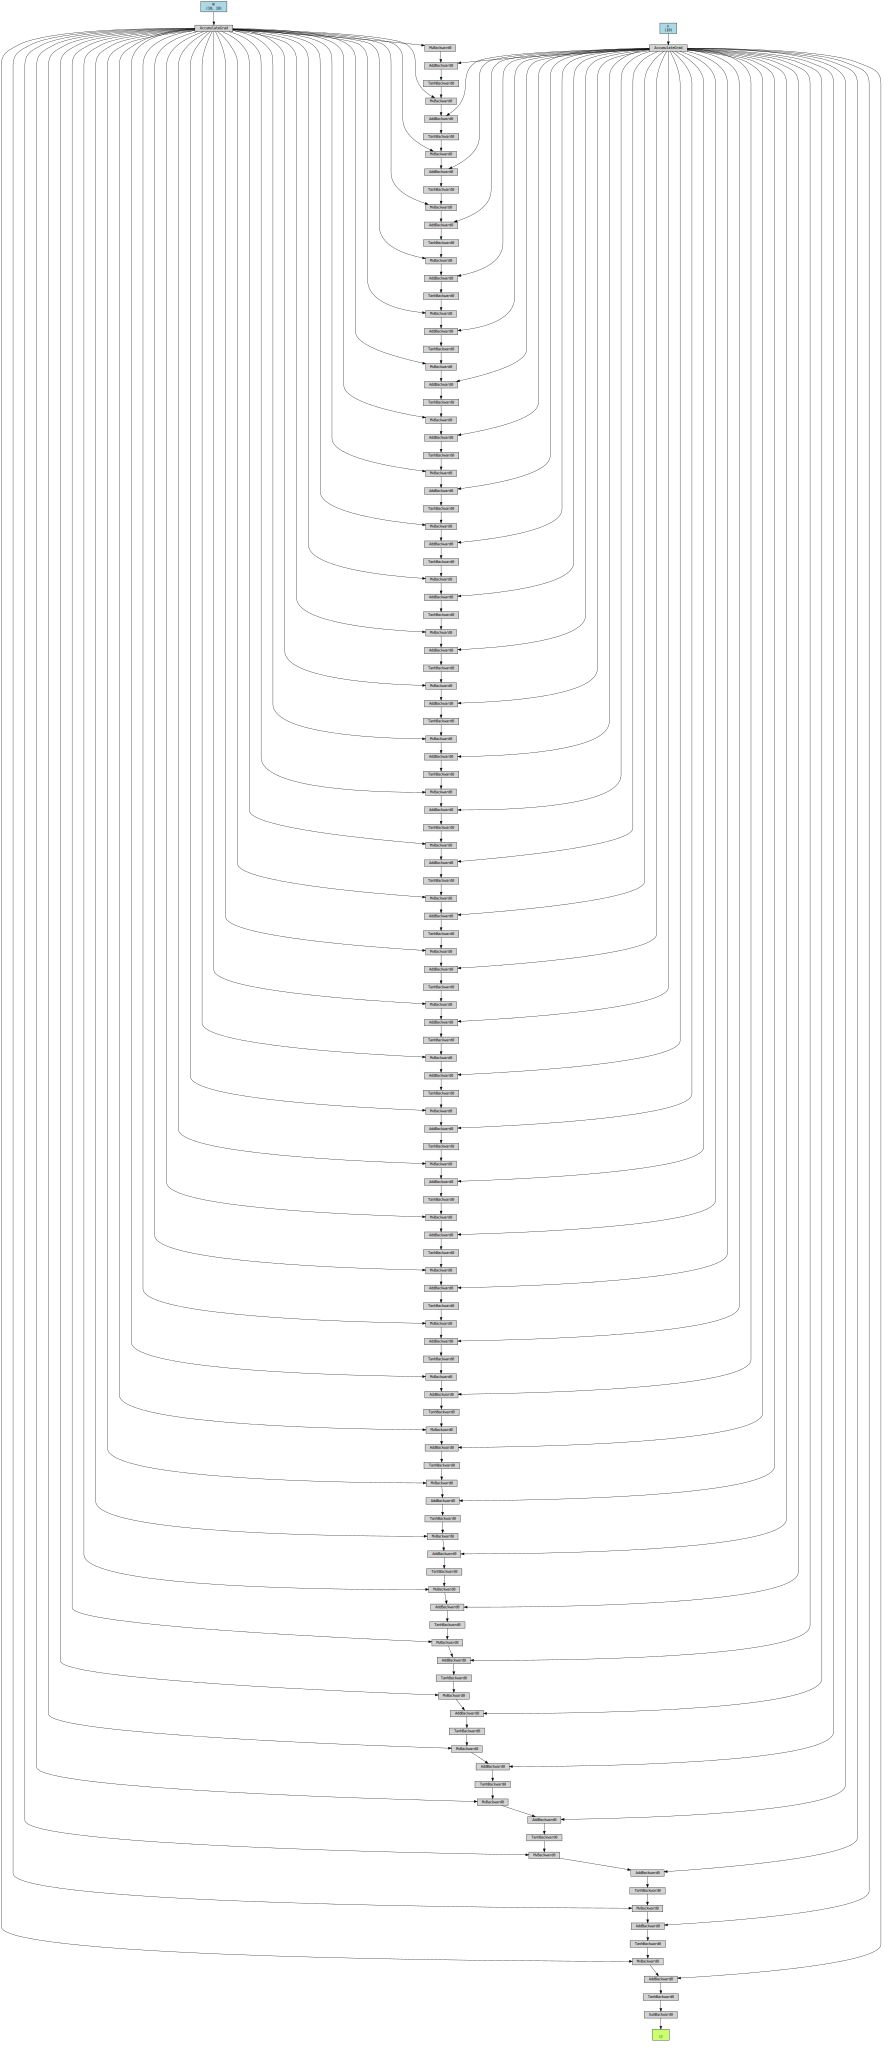

In [ ]:
# Visualizing the computational graph of the network above

graph = make_dot(output.sum(), params={'W': W, 'x': x})
graph.attr('node', shape='record', style='filled', fillcolor='lightblue', fontname='Helvetica', fontsize='10')
graph.node_attr.update(fontsize='12')

graph

# limitation of the approach above
- if we draw the conputational graph, we can see multiple iterations of the solver
- differentiating through all unrolled iterations of the solver can be very ineeficient

**Solution: IMPLICIT Function Theorem**
- We find the expression for the derivative of the fixed point solution using only derivative information of the function f at the fixed point itself. We can save memory!
- Most important take away
            ∂z∗(a0)=[I−∂1f(a0,z0)]−1∂1f(a0,z0)

# The two transformations of autodiff: JVPs and VJPs

# Jacobian Vector Product (JVP)
- If your automatic differentiation system implements JVPs, that means you can evaluate Jacobian matrices one column at a time.
- Each evaluation of a JVP has a similar cost to evaluation of the original function f, requiring at most a small constant multiple of the FLOPs and memory for typical functions

In [ ]:
# JVP: Forward-mode automatic differentiation
def f(x):
  return torch.sin(x) * x**2

x = torch.tensor(2.0, requires_grad=True)
y = f(x)
print(y)

tensor(3.6372, grad_fn=<MulBackward0>)


In [ ]:
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
  delta_x = torch.tensor(1.0)
  y, delta_y = functional.jvp(f, (x,), (delta_x,), create_graph=True)
  print(y)
  print(delta_y)

# Here, \Delta y represents the value of Δy=∂f(x)Δx, evaluated x=2 and Δx=1

/usr/local/lib/python3.10/dist-packages/torch/autograd/profiler.py:228: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


tensor(3.6372, grad_fn=<MulBackward0>)
tensor(1.9726, grad_fn=<AddBackward0>)


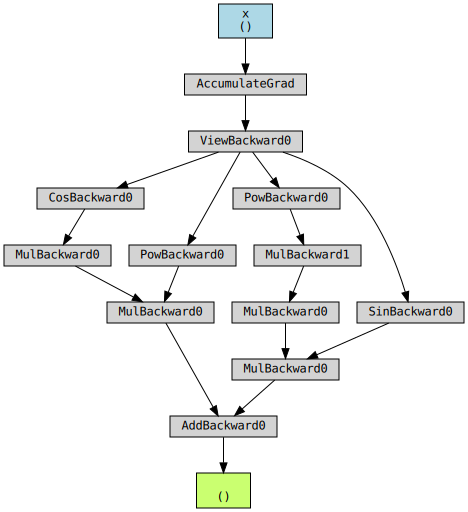

In [ ]:
# Plot JVP computational graph
graph = make_dot(delta_y, params={'x': x, 'delta_x': delta_x})
graph.attr('node', shape='record', style='filled', fillcolor='lightblue', fontname='Helvetica', fontsize='10')
graph.node_attr.update(fontsize='12')

graph

# Vector Jacobian Product (VJP)
- vector-Jacobian products (VJPs) VJPs let us build Jacobian matrices one row at a time,
  - with a computational cost in FLOPs that is just a small constant multiple of the cost of evaluating the original function.
  - However, VJPs have a memory cost that scales with a notion of the depth of a computation, making it much more memory intensive.
- Mathematically, a VJP is the mapping

  $(x,w) → (f(x),wᵀ⋅∂f(x))$ , where w ∈ ℝᵐ is a vector that looks like the output of f

- VJPs answer questions like:
  - At a given input point x∈Rn, if we have a vector w∈Rm that represents a scalar-valued linear function on perturbations Δy of the output, e.g. representing how a scalar-valued loss function changes for small changes to the output, then what is a vector representing the corresponding linear function on perturbations Δx to the input? That is, what is λ ∈ Rn such that

    ⟨w,Δy⟩ = ⟨w,∂f(x)Δx⟩ = ⟨λ,Δx⟩,
    
    for any Δx, where we’ve defined Δy=∂f(x)Δx?

In [ ]:
# VJP: reverse-mode auto-differentiation

# Define the function f
def f(x):
    return torch.sin(x) * x ** 2

# Example usage
x = torch.tensor(2.0, requires_grad=True)

# output vector
w = torch.tensor(1.0)

# Compute the function output and compute the VJP with a vector w
y, lambda_val = torch.autograd.functional.vjp(f, x, create_graph=True)

# Output the results
print("Function output y:", y)                  # Output of f(x)
print("VJP (lambda) value:", lambda_val)        # VJP result


Function output y: tensor(3.6372, grad_fn=<MulBackward0>)
VJP (lambda) value: tensor(1.9726, grad_fn=<AddBackward0>)


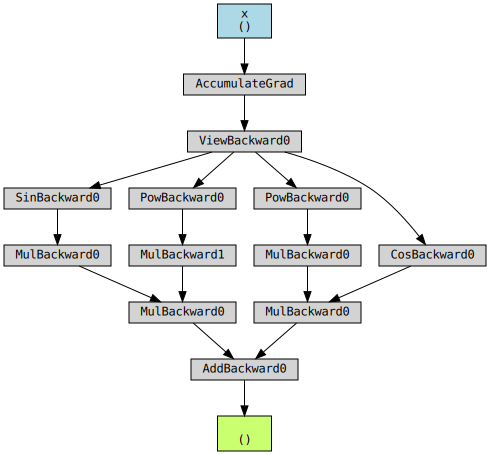

In [ ]:
# plot VJP computational graph
graph = make_dot(lambda_val, params={'x': x, 'w': w})
graph.attr('node', shape='record', style='filled', fillcolor='lightblue', fontname='Helvetica', fontsize='10')
graph.node_attr.update(fontsize='12')

graph

In [ ]:
# VJP: another implementation

# Define the gradient function
def grad(f):
    def gradfun(x):
        x = torch.tensor(x, requires_grad=True)
        y = f(x)
        y.backward()  # Compute the gradient of y with respect to x
        return x.grad  # Return the gradient
    return gradfun

# Define the function f
def f(x):
    return torch.sin(x) * x ** 2

# Example usage
x = 2.0
grad_f = grad(f)  # Create the gradient function
grad_val = grad_f(x)
y = f(torch.tensor(x))
print("Function output y:", y)
print("Gradient of f at x:", grad_val)

# Calculate VJP (Vector-Jacobian Product)
x = torch.tensor(x, requires_grad=True)
y = f(x)
w = torch.tensor(1.0)  # Scalar weight
y.backward(w, create_graph=True)  # Compute the VJP
lambda_val = x.grad  # This is the VJP
print("Function output y after VJP:", y)
print("VJP (lambda) value:", lambda_val)

Function output y: tensor(3.6372)
Gradient of f at x: tensor(1.9726)
Function output y after VJP: tensor(3.6372, grad_fn=<MulBackward0>)
VJP (lambda) value: tensor(1.9726, grad_fn=<CopyBackwards>)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


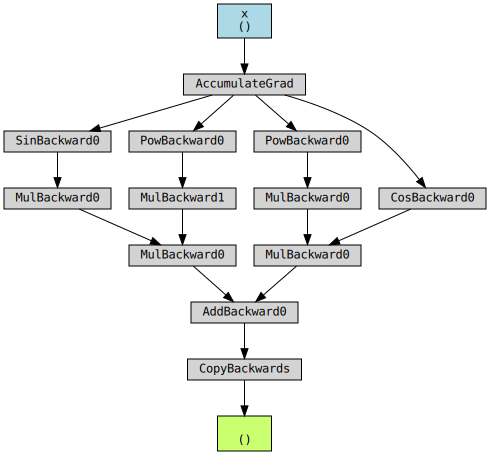

In [ ]:
# plot VJP computational graph
graph = make_dot(lambda_val, params={'x': x, 'w': w})
graph.attr('node', shape='record', style='filled', fillcolor='lightblue', fontname='Helvetica', fontsize='10')
graph.node_attr.update(fontsize='12')

graph

# Back to fixed points: fixed point JVPs and VJPs
- Now the idea is to connect our mathematical implicit differentiation expression to pytorch's autodiff.
- for a fixed point solution mapping z∗, which for any paramter value a∈Rp gives us a solution to the fixed point equation

      z∗(a)=f(a,z∗(a))

we deduced that at a particular point a0 with z0=z∗(a0) we must have

      ∂z∗(a0)=[I−∂1f(a0,z0)]−1∂0f(a0,z0)

In [ ]:
# Hooking implicit differentiation formulas inot pytorch autodiff using functional.jvp and functional.vjp
import torch
from torch.autograd import Function

class FixedPointLayer(Function):
    @staticmethod
    def forward(ctx, solver, f, params, x):
        # Forward pass: compute the fixed point
        z_star = solver(lambda z: f(params, x, z), torch.zeros_like(x))
        ctx.save_for_backward(params, x, z_star)
        ctx.solver = solver
        ctx.f = f
        return z_star

    @staticmethod
    def backward(ctx, z_star_bar):
        # Backward pass: compute the gradients
        params, x, z_star = ctx.saved_tensors
        solver = ctx.solver
        f = ctx.f

        # Calculate VJP for params and x
        _, vjp_params_x = torch.autograd.functional.vjp(lambda p, x: f(p, x, z_star), params, x)
        _, vjp_z = torch.autograd.functional.vjp(lambda z: f(params, x, z), z_star)

        # Solve for the backward pass
        grad_params, grad_x = vjp_params_x(solver(lambda u: vjp_z(u)[0] + z_star_bar, torch.zeros_like(z_star)))

        return None, None, grad_params, grad_x

# Function to create the custom fixed-point layer
def fixed_point_layer(solver, f, params, x):
    return FixedPointLayer.apply(solver, f, params, x)

# Example Usage:
def f(params, x, z):
    return torch.tanh(torch.matmul(params, z) + x)

def solver(func, z_init):
    # A simple fixed-point solver (e.g., using iteration)
    z = z_init
    for _ in range(10):  # fixed number of iterations
        z = func(z)
    return z

params = torch.randn((10, 10), requires_grad=True)
x = torch.randn((10,), requires_grad=True)

z_star = fixed_point_layer(solver, f, params, x)

# Perform backpropagation
z_star.sum().backward()
